<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_knn_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1Ktdv2NTyK2AM48yBvbpFezd82-srqj7w/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  cleaned_app_df=pd.read_csv(url,index_col=0)
else:
  pathtoapp="/content/cleaned_application.csv"
  cleaned_app_df=pd.read_csv(pathtoapp,index_col=0)
path_to_avg_label="/content/average_label.csv"
path_to_evm_label="/content/expo_moving_labels.csv"
avg_df=pd.read_csv(path_to_avg_label,index_col=0)
ewm_df=pd.read_csv(path_to_evm_label,index_col=0)

In [237]:
labels_to_int_evm={"bad":1,"neutral":2,"good":3}
labels_to_int_avg={"very bad":0,"bad":1,"neutral":2,"good":3}

In [238]:
avg_df=avg_df.replace({"label":labels_to_int_avg})
ewm_df=ewm_df.replace({"label":labels_to_int_evm})

In [239]:
dep_var="label"
random_state=42

In [240]:
from sklearn.model_selection import ShuffleSplit
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from fastai.tabular.all import *
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [241]:
train_df=ewm_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [242]:
cont,cat = cont_cat_split(train_df, max_card=1, dep_var=dep_var)

In [243]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [244]:
procs = [Categorify, Normalize]
to = TabularPandas(train_df, procs, cat, cont,
                      splits=splits, y_names=dep_var)

In [245]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [246]:
m = DecisionTreeClassifier(max_depth=18,random_state=random_state)
m.fit(xs, y)

DecisionTreeClassifier(max_depth=18, random_state=42)

In [247]:
preds=m.predict(valid_xs)

In [249]:
#int_to_labels_evm={1:"bad",2:"good"}
int_to_labels_evm={v:k for k,v in enumerate(labels_to_int_evm)}

              precision    recall  f1-score   support

         bad       0.41      0.53      0.46      1988
     neutral       0.76      0.59      0.66      4817
        good       0.27      0.53      0.36       487

    accuracy                           0.57      7292
   macro avg       0.48      0.55      0.49      7292
weighted avg       0.63      0.57      0.59      7292



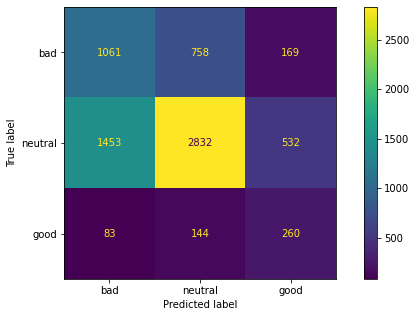

In [250]:
print(classification_report(preds,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(preds, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [256]:
def rf(xs, y, n_estimators=40, max_samples=20_000,
       max_features=0.5, min_samples_leaf=5,random_state=random_state):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,random_state=random_state).fit(xs, y)

In [257]:
rf_m = rf(xs, y)
preds_rf=rf_m.predict(valid_xs)

              precision    recall  f1-score   support

         bad       0.46      0.57      0.51      2115
     neutral       0.78      0.60      0.68      4854
        good       0.20      0.60      0.30       323

    accuracy                           0.59      7292
   macro avg       0.48      0.59      0.50      7292
weighted avg       0.66      0.59      0.61      7292



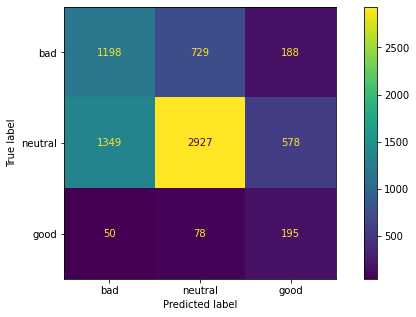

In [258]:
print(classification_report(preds_rf,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(preds_rf, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [259]:
from lightgbm import LGBMClassifier

In [260]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(xs,y)

LGBMClassifier(random_state=42)

              precision    recall  f1-score   support

         bad       0.19      0.55      0.28       883
     neutral       0.92      0.54      0.68      6337
        good       0.06      0.81      0.11        72

    accuracy                           0.55      7292
   macro avg       0.39      0.63      0.36      7292
weighted avg       0.82      0.55      0.63      7292



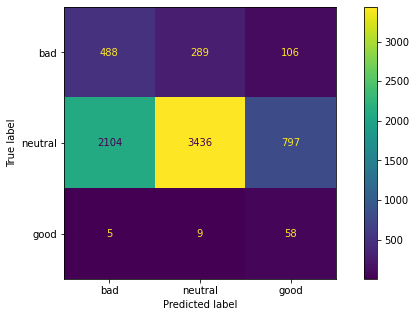

In [261]:
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(pred_boost,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(pred_boost, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

It seems that the random forest is the best at detecting bad clients with a 50% precision rate, we would be compressing neutral with good when we make a prediction

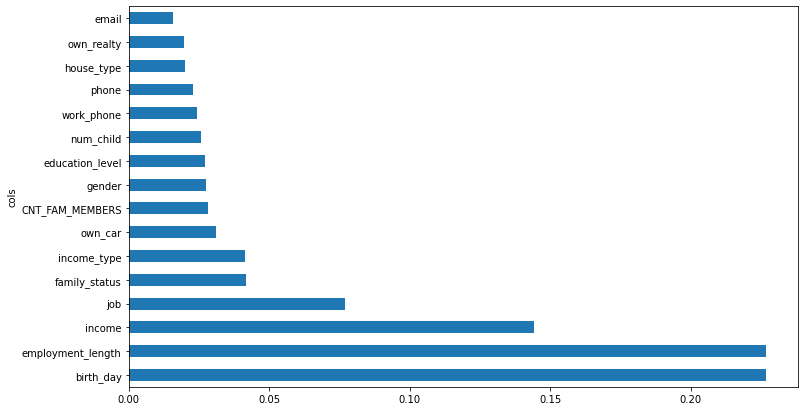

In [262]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi);

We can drop weak learners from looking at our random forest feature importance.
We define a weak learner as less than 0.05 feature importance.

In [263]:
imp_cols=fi[fi["imp"]>0.05]

We can do KNN with the dataset with the reduced dimension

In [264]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [265]:
imp_X=train_df[np.array(imp_cols.cols)]
y=train_df["label"]

We one hot code the jobs before we train test split incase we split and lose a job

In [266]:
jobs=pd.get_dummies(imp_X["job"])

In [267]:
to_split=imp_X.drop(columns="job").join(jobs)

In [268]:
cont=imp_X._get_numeric_data().columns

In [269]:
X_knn,valid_X_knn,y_knn,valid_y_knn=train_test_split(to_split,y,random_state=random_state)

In [270]:
# take k= sqrt(len(features))
k=round(math.sqrt(X_knn.shape[0]))
# k should be odd
if k %2 ==0:
  k+=1

We standardise the numerical cols using training data

In [271]:
from sklearn.preprocessing import StandardScaler
knn_standard=StandardScaler()
knn_standard.fit(X_knn[cont])

StandardScaler()

In [272]:
scaled_features=knn_standard.transform(X_knn[cont])
X_knn[cont]=scaled_features

In [273]:
valid_scaled_features=knn_standard.transform(valid_X_knn[cont])
valid_X_knn[cont]=valid_scaled_features

In [274]:
knn=KNeighborsClassifier(k)

In [275]:
knn.fit(X_knn,y_knn)

KNeighborsClassifier(n_neighbors=165)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         bad       0.10      0.44      0.17       763
     neutral       0.93      0.51      0.66      8352
        good       0.00      0.00      0.00         0

    accuracy                           0.51      9115
   macro avg       0.34      0.32      0.28      9115
weighted avg       0.86      0.51      0.62      9115



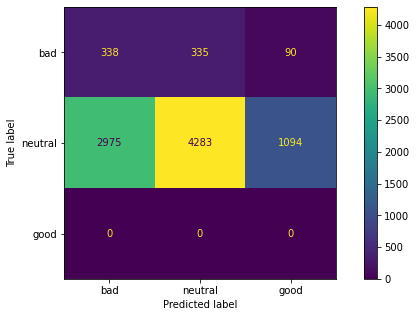

In [276]:
preds_knn=knn.predict(valid_X_knn)
print(classification_report(preds_knn,valid_y_knn,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(preds_knn,valid_y_knn,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 